In [ ]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl

In [ ]:
# !huggingface-cli login
from huggingface_hub import login
login("token")

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

# Model from Hugging Face hub
base_model = "clibrain/Llama-2-7b-ft-instruct-es"

# New instruction dataset
emotion_dataset = "Joseph7D/prompt-emotion-dataset-v2"

In [ ]:
dataset = load_dataset(emotion_dataset, split='test')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/671 [00:00<?, ?B/s]

(…)-00000-of-00001-0c67affb9210ad40.parquet:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

(…)-00000-of-00001-4f62525995947485.parquet:   0%|          | 0.00/300k [00:00<?, ?B/s]

(…)-00000-of-00001-99d9ca9cf25d3c0d.parquet:   0%|          | 0.00/300k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26934 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3366 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3372 [00:00<?, ? examples/s]

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

In [ ]:
!kill 26235

/bin/bash: line 1: kill: (26235) - No such process


# TEST

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import re
# Separar prompt (input) y etiqueta (label) del formato instruct
def parse_sample(sample):
    text = sample["text"]  # campo 'text' del dataset
    inst_match = re.search(r"\[INST\](.*?)\[/INST\]", text, re.DOTALL)
    label_match = re.search(r"\[/INST\](.*?)</s>", text, re.DOTALL)

    if inst_match and label_match:
        input_text = inst_match.group(1).strip()
        label = label_match.group(1).strip().lower()
        return {"input": input_text, "label": label}
    else:
        return None

parsed_data = [parse_sample(s) for s in dataset if parse_sample(s)]


In [ ]:
import random
import torch
import re
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Suponiendo que etiquetas válidas están definidas
etiquetas_validas = ["ira", "disgusto", "tristeza", "alegría", "miedo", "neutral"]
true_labels = []
pred_labels = []
model.eval()

# for sample in parsed_data:
for sample in tqdm(parsed_data, desc="Testing samples"):
    prompt = f"[INST] {sample['input']} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=20,  # Aumentado para evitar truncamiento
            do_sample=False
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    # Extracción de la respuesta posterior a "### Respuesta:"
    pred = decoded.split("### Respuesta:")[-1].strip().lower()
    # Normalizar predicción: quitar símbolos, espacios extras, etc.
    pred = pred.replace("</s>", "").replace("<s>", "").strip()
    # Corrección por coincidencia parcial (opcional)
    pred = next((etiqueta for etiqueta in etiquetas_validas if etiqueta.startswith(pred)), pred)

    true_labels.append(sample["label"])
    pred_labels.append(pred)

# Reportes
print("=== CLASSIFICATION REPORT ===")
print(classification_report(true_labels, pred_labels, labels=etiquetas_validas, zero_division=0, digits=4))

print("=== CONFUSION MATRIX ===")
print(confusion_matrix(true_labels, pred_labels, labels=etiquetas_validas))


Testing samples: 100%|██████████| 3366/3366 [1:06:22<00:00,  1.18s/it]

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         ira     0.0544    0.0624    0.0581       561
    disgusto     0.9637    0.6631    0.7856       561
    tristeza     0.6848    0.1123    0.1930       561
     alegría     0.0000    0.0000    0.0000       561
       miedo     0.3452    0.8485    0.4907       561
     neutral     0.2658    0.1426    0.1856       561

   micro avg     0.3641    0.3048    0.3318      3366
   macro avg     0.3857    0.3048    0.2855      3366
weighted avg     0.3857    0.3048    0.2855      3366

=== CONFUSION MATRIX ===
[[ 35  12  11   4 316  47]
 [  6 372   3   4  85   7]
 [ 33   1  63   5 192  87]
 [395   0   3   0  63  55]
 [ 14   1   5   3 476  25]
 [160   0   7   1 247  80]]


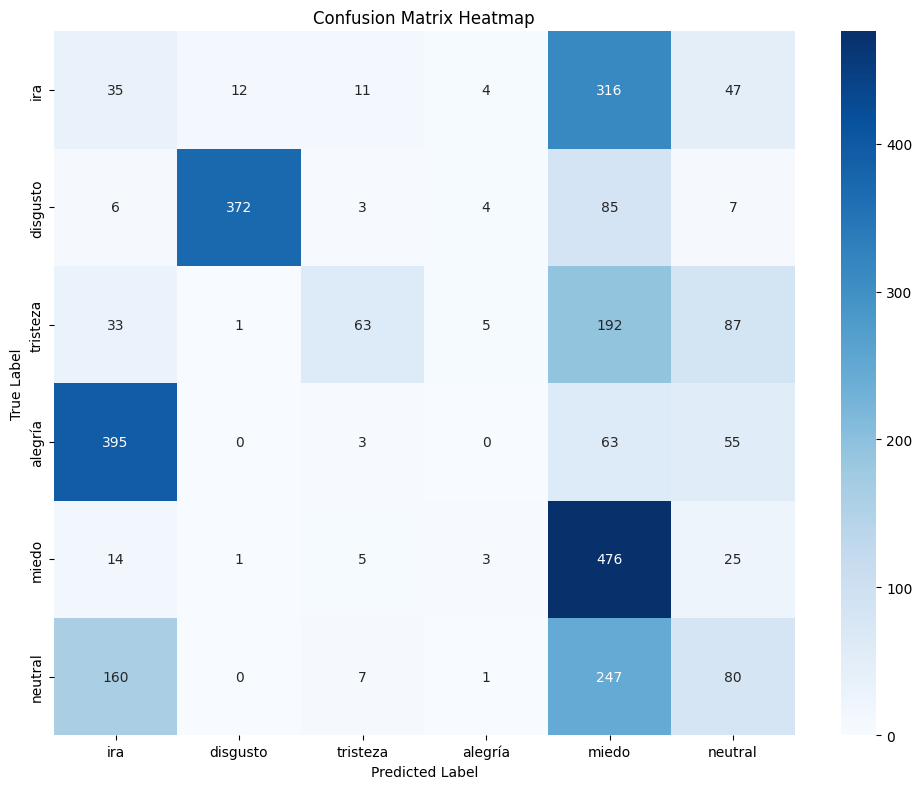

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Obtener etiquetas únicas (ordenadas por aparición en etiquetas reales)
labels = etiquetas_validas

# Matriz de confusión como array
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Crear mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Etiquetas y título
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()
